In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit, train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer

from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer

from operator import *
import pickle
from IPython.display import Image

In [4]:
mydateparse = lambda dt: pd.to_datetime(dt,format="%Y-%m-%d")

df_train = pd.read_csv("features/df_fourier_no_zeros",parse_dates=['Date'],date_parser=mydateparse)

df_test = pd.read_csv("df_test_with_no_zeros")

In [5]:
# Removing the duplicate column
df_test = df_test.drop(df_test.columns[-1],axis=1)

In [6]:
def rmspe(y,yhat):
    rmspe = np.sqrt(np.mean(((y-yhat)/y)**2))
    return rmspe

def rmspe_xg(yhat,y):
    
    y = y.get_label()
    rmspe = np.sqrt(np.mean(((y-yhat)/y)**2))
    return "rmspe",rmspe

scorer = make_scorer(rmspe,greater_is_better=False)

In [7]:
df_train.head(5)

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,SalesLog,StoreType,...,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3
0,1,5,2013-02-01,5633,1,0,0,0,8.636575,c,...,NaN,NaN,NaN,4649.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
1,1,5,2013-03-01,4611,1,0,0,0,8.436417,c,...,5085.666667,NaN,NaN,4649.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
2,1,6,2013-06-01,5693,1,0,0,0,8.647168,c,...,5149.300000,NaN,NaN,4773.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
3,1,1,2013-07-01,5614,1,1,0,0,8.633197,c,...,4773.866667,NaN,NaN,5280.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
4,1,4,2013-08-01,4994,1,1,0,1,8.516193,c,...,4774.566667,NaN,NaN,4380.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778


In [8]:
df_train.sort_values("Date",inplace=True)

In [9]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,SalesLog,StoreType,...,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3
542,85,2,2013-01-01,4220,1,0,a,1,8.347827,b,...,NaN,NaN,NaN,6746.0,7202.0,6621.0,-0.005612,0.113356,167823.404310,151474.773924
2753,423,2,2013-01-01,9643,1,0,a,1,9.174091,b,...,NaN,NaN,NaN,10195.0,11338.0,10598.0,-0.119658,-0.227564,365705.744312,247568.075518
7175,1097,2,2013-01-01,5961,1,0,a,1,8.693161,b,...,NaN,NaN,NaN,9443.0,10222.0,8875.0,-0.119914,-0.001071,284199.318582,248669.925246
1693,262,2,2013-01-01,17267,1,0,a,1,9.756610,b,...,NaN,NaN,NaN,18856.0,20251.0,19200.5,-0.123333,0.124444,444458.857440,344153.269707
3343,512,2,2013-01-01,2646,1,0,a,1,7.881182,b,...,NaN,NaN,NaN,5174.5,5724.0,5186.5,0.001357,-0.005427,241086.454067,101319.181792


# Preprocessing the Data

In [10]:
# Removing some features after VIF analaysis done in Feature Engineering
df_1 = df_train.drop(['Date'],axis=1)

In [11]:
df_test = df_test.rename(columns={'Sales_per_day':'SalesPerDay',
                                  'holidays_this_week':'holiday_this_week',
                                  'holidays_last_week': 'holiday_last_week',
                                   'holidays_next_week': 'holiday_next_week',
                                    'Customers_per_day':'CustomerPerDay',
                                    'Median_over_day_week':'Median_over_day_of_week',
                                     'Sales_Per_Customers_Per_Day':'SalesPerCustomerPerDay'})

In [12]:
for i in df_test.columns:
    if i not in df_1.columns:
        print(i)

Id


In [13]:
for i in df_1.columns:
    if i not in df_test.columns:
        print(i)

Sales
SalesLog
State
Promo_median_sales
Holiday_median_sales


In [14]:
df_1.drop(['Promo_median_sales','Holiday_median_sales','State'],axis=1,inplace=True)

In [15]:
df_1.isnull().sum()

Store                              0
DayOfWeek                          0
Sales                              0
Open                               0
Promo                              0
StateHoliday                       0
SchoolHoliday                      0
SalesLog                           0
StoreType                          0
Assortment                         0
CompetitionDistance             2169
CompetitionOpenSinceMonth     266454
CompetitionOpenSinceYear      266454
Promo2                             0
Promo2SinceWeek               420089
Promo2SinceYear               420089
Year                               0
Month                              0
Day                                0
WeekOfYear                         0
DayOfYear                          0
holiday_this_week                  0
holiday_last_week               7047
holiday_next_week               5673
State_holiday_before_days          0
State_holiday_after_days           0
Promo_before_days                  0
P

In [16]:
df_1[['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','PromoOpen']] = df_1[['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','PromoOpen']].fillna(-1)

df_test[['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','PromoOpen']] = df_test[['Promo2SinceWeek','Promo2SinceYear','PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3','PromoOpen']].fillna(-1)

In [17]:
df_test.isnull().sum()

Id                                0
Store                             0
DayOfWeek                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance              96
CompetitionOpenSinceMonth     15216
CompetitionOpenSinceYear      15216
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
DayOfYear                         0
holiday_this_week                 0
holiday_last_week             41088
holiday_next_week             41088
State_holiday_before_days         0
State_holiday_after_days          0
Promo_before_days                 0
Promo_after_days                  0
School_Holiday_before_days  

In [18]:
df_1['StateHoliday'].replace(0,'0',inplace=True)
df_test['StateHoliday'].replace(0,'0',inplace=True)

In [19]:
df_test['StateHoliday'].value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

In [20]:
X = df_1.drop(['SalesLog','Sales'],axis=1)
y = df_1['Sales']

In [28]:
#Some Test ids where Open will be equal to zero.
b = [480, 1336, 2192, 3048, 4760, 5616, 6472, 7328, 8184, 9040, 10752]
#Saving Ids for further use.
ids = df_test['Id'].values
#Saving test ids where store were closed.
closed_test_ids = df_test.loc[df_test['Open']==0]['Id']
#Dropping column Id as it is not in training data.
df_test.drop(['Id','Open'], axis=1, inplace=True)

In [97]:
X.drop(['Open'],axis=1,inplace=True)

# BASELINE MODEL 

I have created the a model to check with performance of the model with using new features 

In [48]:
base_X = X[['Store', 'DayOfWeek', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year',
            'Month', 'Day', 'WeekOfYear', 'DayOfYear',  'SalesPerDay', 'CustomerPerDay', 'SalesPerCustomerPerDay', 
            'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']]

y = df_1['Sales']

In [49]:
print("Base X shape = ",base_X.shape)
print("y shape = ",y.shape)

Base X shape =  (837940, 25)
y shape =  (837940,)


In [50]:
base_df = pd.concat([base_X,y],axis=1)

In [51]:
base_submit = df_test[['Store', 'DayOfWeek', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year',
            'Month', 'Day', 'WeekOfYear', 'DayOfYear',  'SalesPerDay', 'CustomerPerDay', 'SalesPerCustomerPerDay', 
            'PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']]

In [52]:
cat_cols = ['StoreType','Assortment','StateHoliday','DayOfWeek','Promo','Year','Promo2']
num_cols = [i for i in base_X.columns if i not in cat_cols]

num_transformer = Pipeline(steps = [('imp', IterativeImputer(initial_strategy='median')),
                                    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps = [('imp', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer,num_cols),
                                               ('cat',cat_transformer,cat_cols)])

In [53]:
preprocessor.fit(base_X)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imp',
                                                  IterativeImputer(initial_strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Store', 'SchoolHoliday',
                                  'CompetitionDistance',
                                  'CompetitionOpenSinceMonth',
                                  'CompetitionOpenSinceYear', 'Promo2SinceWeek',
                                  'Promo2SinceYear', 'Month', 'Day',
                                  'WeekOfYear', 'DayOfYear', 'SalesPerDay',
                                  'CustomerPerDay', 'SalesPerCustomerPerDay',
                                  'PromoInterval0', 'PromoInterval1',
                                  'PromoInterval2', 'PromoInterval3']),
                                ('cat',
                                 Pipeline(steps=[('imp',
   

In [54]:
X_transformed = preprocessor.transform(base_X)
x_test = preprocessor.transform(base_submit)

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed,
                                                   y,
                                                   shuffle=False,
                                                   random_state=21,
                                                   test_size=0.2)

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
model = RandomForestRegressor(max_depth=20, n_jobs=-1,random_state=12)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=12)

In [59]:
train_preds = model.predict(X_train)
rmspe(y_train,train_preds)

0.09793552367850146

In [60]:
preds = model.predict(X_test)
rmspe(y_test,preds)

0.179902529737327

In [61]:
model.fit(X_transformed,y)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=12)

In [62]:
preds = model.predict(x_test)

In [63]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  # 0.983 is a correction factor.

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('predictions/rossmann_base_model.csv', index=False)

# Models after adding new features that were generated without feature Selection

In [104]:
base_X = df_1.drop(['Sales','SalesLog','Open'],axis=1)
y = df_1['Sales']

In [65]:
base_df = pd.concat([base_X,y])

In [66]:
base_test = df_test[base_X.columns]

In [68]:
cat_cols = ['StoreType','Assortment','StateHoliday','DayOfWeek','Promo','Year','Promo2']
num_cols = [i for i in base_X.columns if i not in cat_cols]

num_transformer = Pipeline(steps = [('imp', IterativeImputer(initial_strategy='median')),
                                    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps = [('imp', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer,num_cols),
                                               ('cat',cat_transformer,cat_cols)]) 

In [69]:
preprocessor.fit(base_X)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imp',
                                                  IterativeImputer(initial_strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Store', 'SchoolHoliday',
                                  'CompetitionDistance',
                                  'CompetitionOpenSinceMonth',
                                  'CompetitionOpenSinceYear', 'Promo2SinceWeek',
                                  'Promo2SinceYear', 'Month', 'Day',
                                  'WeekOfYear', 'DayOfYear',
                                  'holiday_this_week', 'holiday_last_we...
                                  'CustomerPerDay', 'SalesPerCustomerPerDay',
                                  'CompetitionOpen', 'PromoOpen',
                                  'PromoInterval0', 'PromoInterval1',
                                  'PromoInterv

In [75]:
X_transformed = preprocessor.transform(base_X)
X_submit = preprocessor.transform(base_test)

In [77]:
'''
import pickle

with open('X_transformed','wb') as f:
    pickle.dump(X_transformed,f)
    
with open('x_test','wb') as f:
    pickle.dump(X_submit,f)
'''

"\nimport pickle\n\nwith open('X_transformed','wb') as f:\n    pickle.dump(X_transformed,f)\n    \nwith open('x_test','wb') as f:\n    pickle.dump(X_submit,f)\n"

# Splitting the data into Train and Test (80:20)

In [78]:
X_transformed = pickle.load(open('X_transformed','rb'))
x_submit = pickle.load(open('x_test','rb'))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed,y,shuffle=False,
                                random_state=12, test_size=0.2)

In [80]:
print("X_trian Shape : ",X_train.shape)
print("y_trian Shape : ",y_train.shape)
print("X_test Shape : ",X_test.shape)
print("y_test Shape : ",y_test.shape)

X_trian Shape :  (670352, 65)
y_trian Shape :  (670352,)
X_test Shape :  (167588, 65)
y_test Shape :  (167588,)


# Model 1: SGD Regressor

In [90]:
from sklearn.linear_model import LinearRegression



model = SGDRegressor(eta0=0.1, fit_intercept=False, shuffle=False, 
                    learning_rate='adaptive',random_state=12)

model.fit(X_train,y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
test_predictions

array([ 8402.78568913,  7676.05585063, 11617.36999675, ...,
        9459.97604139,  5287.43844279,  8330.0965462 ])

In [91]:
print("RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("RMSPE: Metric score for test set = ",rmspe(y_test,test_predictions))

RMSPE: Metric score for train set =  0.11952648505238313
RMSPE: Metric score for test set =  0.1019799231473123


### Hyper-parameter Tunning for SGD Regressor


In [ ]:
model = SGDRegressor()
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 4),
    'loss': ['squared_loss'],
    'penalty': ['l2'],
    'learning_rate': ['constant', 'optimal','adaptive'],
}
clf = RandomizedSearchCV(model, param_grid)
clf.fit(X_train, y_train)

In [ ]:
print(clf.best_params_)

In [92]:
model = SGDRegressor(eta0=0.1, fit_intercept=False, shuffle=False, 
                    learning_rate='adaptive',random_state=12)

model.fit(X_train,y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
test_predictions

array([ 8402.78568913,  7676.05585063, 11617.36999675, ...,
        9459.97604139,  5287.43844279,  8330.0965462 ])

In [93]:
print("SGD Regressor - RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("SGD Regressor - RMSPE: Metric score for test set = ",rmspe(y_test,test_predictions))

SGD Regressor - RMSPE: Metric score for train set =  0.11952648505238313
SGD Regressor - RMSPE: Metric score for test set =  0.1019799231473123


In [94]:
model.fit(X_transformed,y)
preds = model.predict(X_submit)

In [96]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('predictions/rossmann_sgd.csv', index=False)

# Model 2 : Random Forest Model 

In [99]:
# Create the parameter grid based on the results of random search 
model = RandomForestRegressor()
param_grid_rf = {
    'max_depth': [80, 90, 100 ],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}

#Instantiate the grid search model
random_search = RandomizedSearchCV(model,param_grid_rf, 
                          cv = 2, n_jobs = 8)

random_search.fit(X_train,y_train)
print(random_search.best_params_)

{'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 80}


In [100]:
# Training the model with Best Hyper-parameters
model = RandomForestRegressor(n_estimators=500, max_depth=80,n_jobs=-1,min_samples_leaf=3,random_state=12,min_samples_split=8)
model.fit(X_train,y_train)

train_predictions = model.predict(X_train)
test_predicitions = model.predict(X_test)
test_predicitions

array([ 8389.25472989,  7954.46749704, 12570.98026583, ...,
       10389.70077573,  5355.09973659,  9263.2452138 ])

In [101]:
print("Random Forest - RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("Random Forest - RMSPE: Metric score for test set = ",rmspe(y_test,test_predictions))

Random Forest - RMSPE: Metric score for train set =  0.07499194085907833
Random Forest - RMSPE: Metric score for test set =  0.1019799231473123


In [102]:
model.fit(X_transformed,y)
preds = model.predict(X_submit)

In [103]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('predictions/rossmann_RF.csv', index=False)

# Model 3 : XGBoost 

In [37]:
from xgboost.sklearn import XGBRegressor

# Hyper-parameter Tunning 
xgb = XGBRegressor()
parameters = { 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6 ,7 ,10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500 ]}

xgb_grid = RandomizedSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 8,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[18:25:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9716622665820336
{'subsample': 0.7, 'silent': 1, 'objective': 'reg:linear', 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [81]:
from xgboost.sklearn import XGBRegressor

xgb_model = XGBRegressor(n_estimators=500,
                         max_depth=10,
                         learning_rate=0.05,
                         min_child_weight = 4,
                         n_jobs=-1)
xgb_model.fit(X_train,y_train)

train_predictions = xgb_model.predict(X_train)
test_predicitions = xgb_model.predict(X_test)
test_predicitions

array([ 8271.266 ,  7979.078 , 12458.1875, ..., 10286.658 ,  5657.482 ,
        8967.198 ], dtype=float32)

In [87]:
print("XGBoost - RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("XGBoost - RMSPE: Metric score for test set = ",rmspe(y_test,test_predicitions))

XGBoost - RMSPE: Metric score for train set =  0.04336950533090824
XGBoost - RMSPE: Metric score for test set =  0.0714714804074702


In [88]:
model.fit(X_transformed,y)
preds = model.predict(X_submit)

In [89]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('predictions/rossmann_xgboost.csv', index=False)

# Models after adding new features that were generated after feature Selection

In [109]:
base_X

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Acceleration,Weekly_rolling_mean,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3
542,85,2,0,a,1,b,a,1870.0,10.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,6746.0,-0.005612,0.113356,167823.404310,151474.773924
2753,423,2,0,a,1,b,a,1270.0,5.0,2014.0,...,NaN,NaN,NaN,NaN,NaN,10195.0,-0.119658,-0.227564,365705.744312,247568.075518
7175,1097,2,0,a,1,b,b,720.0,3.0,2002.0,...,NaN,NaN,NaN,NaN,NaN,9443.0,-0.119914,-0.001071,284199.318582,248669.925246
1693,262,2,0,a,1,b,a,1180.0,5.0,2013.0,...,NaN,NaN,NaN,NaN,NaN,18856.0,-0.123333,0.124444,444458.857440,344153.269707
3343,512,2,0,a,1,b,b,590.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5174.5,0.001357,-0.005427,241086.454067,101319.181792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836274,555,5,1,0,0,d,a,1560.0,1.0,2014.0,...,990.0,5544.000000,5110.966667,NaN,NaN,5211.5,0.012966,-0.001621,122518.613818,115656.305525
836271,554,5,1,0,1,c,c,1200.0,NaN,NaN,...,-2014.0,5921.714286,5576.366667,NaN,NaN,4251.0,-0.001279,0.002558,205489.223714,135516.126659
836268,553,5,1,0,1,c,a,3040.0,9.0,2002.0,...,848.0,8854.714286,7774.066667,NaN,NaN,6891.0,-0.006460,0.002584,185328.222141,147038.581368
836299,563,5,1,0,1,a,a,700.0,3.0,2015.0,...,631.0,4323.285714,4437.200000,NaN,NaN,5040.0,0.003942,0.006570,176672.227334,167181.119424


In [118]:
base_X.select_dtypes(exclude=['int','float']).columns.tolist()

['StateHoliday', 'StoreType', 'Assortment']

In [54]:
numeric_cols = ['Store',
 'DayOfWeek',
 'Promo',
 'SchoolHoliday',
 'Promo2',
 'Year',
 'Month',
 'Day',
 'WeekOfYear',
 'DayOfYear',
 'holiday_this_week',
 'State_holiday_before_days',
 'State_holiday_after_days',
 'Promo_before_days',
 'Promo_after_days',
 'School_Holiday_before_days',
 'School_Holiday_after_days',
 'CustomerPerDay',
  'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'holiday_last_week',
 'holiday_next_week',
 'SalesPerDay',
 'SalesPerCustomerPerDay',
 'CompetitionOpen',
 'PromoOpen',
 'PromoInterval0',
 'PromoInterval1',
 'PromoInterval2',
 'PromoInterval3',
 'Variation',
 'Acceleration',
 'Weekly_rolling_mean',
 'Monthly_rolling_mean',
 'Previous_quarter_median',
 'Previous_half_year_median',
 'Median_over_day_of_week',
 'Frequency_2',
 'Frequency_3',
 'Amplitude_2',
 'Amplitude_3']

In [55]:
categorical_cols = ['StateHoliday', 'StoreType', 'Assortment']

In [120]:
base_X.columns.shape

(47,)

In [123]:
len(numeric_cols)

44

In [124]:
len(categorical_cols)

3

In [ ]:
# Handing Missinng and Scaling Numerical data
base_numeric = base_X[numeric_cols]

# Impute training data
imputer = IterativeImputer(initial_strategy='median')
X_train_imputed = imputer.fit_transform(base_numeric)

# Encode training data
scaler = StandardScaler()
X_encoded_numeric = scaler.fit_transform(X_train_imputed)


In [141]:
scaled_numeric_df = pd.DataFrame(X_encoded_numeric, columns = base_numeric.columns)

In [142]:
scaled_numeric_df

,Store,DayOfWeek,Promo,SchoolHoliday,Promo2,Year,Month,Day,WeekOfYear,DayOfYear,...,Acceleration,Weekly_rolling_mean,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3
0,-1.471732,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,...,-0.238967,0.160205,-0.095660,0.210221,0.151726,-0.065961,-0.016845,0.946975,-0.632146,-0.255585
1,-0.421112,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,...,-0.158961,1.482732,1.277672,1.348807,1.423534,1.236686,-2.386833,-2.471377,1.441242,1.227970
2,1.673913,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,...,-0.191911,1.158556,0.876468,0.964785,0.994309,0.952665,-2.392158,-0.200362,0.587227,1.244981
3,-0.921555,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,...,0.228862,5.081734,5.121030,4.608242,5.057815,4.507846,-2.463207,1.058159,2.266408,2.719120
4,-0.144469,-0.891015,-0.894026,2.045802,1.002674,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,...,-0.015869,0.135926,-0.400347,-1.421157,-0.791775,-0.659499,0.127967,-0.244046,0.135495,-1.029922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837935,-0.010810,0.854130,1.118536,-0.488806,1.002674,1.500444,0.356581,1.748584,0.521716,0.499642,...,0.483301,-0.524245,-0.727043,-0.644865,-0.639163,-0.645524,0.369215,-0.205877,-1.106845,-0.808575
837936,-0.013918,0.854130,1.118536,2.045802,-0.997333,1.500444,0.356581,1.748584,0.521716,0.499642,...,-0.985128,-0.378191,-0.537779,-0.902488,-0.789486,-1.008294,0.073196,-0.163982,-0.237488,-0.501966
837937,-0.017027,0.854130,1.118536,2.045802,1.002674,1.500444,0.356581,1.748584,0.521716,0.499642,...,0.413888,0.755937,0.355961,0.176567,0.179357,-0.011196,-0.034473,-0.163717,-0.448733,-0.324074
837938,0.014057,0.854130,1.118536,2.045802,1.002674,1.500444,0.356581,1.748584,0.521716,0.499642,...,0.307813,-0.996269,-1.001044,-0.732517,-0.710726,-0.710298,0.181692,-0.123747,-0.539430,-0.013099


In [155]:
base_categorical = base_X[categorical_cols]

# Impute training data
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(base_categorical)

# Encode training data
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded_categorical = encoder.fit_transform(X_train_imputed)

column_name = encoder.get_feature_names(['StateHoliday', 'StoreType', 'Assortment'])
scaled_categorical_df =  pd.DataFrame(X_encoded_categorical.todense(), columns= column_name)
    

In [172]:
base_XX = pd.concat([scaled_numeric_df.reset_index(drop=True), scaled_categorical_df.reset_index(drop=True)], axis=1)
y = df_1['Sales']

In [193]:
base_XX.to_csv("Scaled_data_for_feature_selection.csv")

In [26]:
base_XX = pd.read_csv("Scaled_data_for_feature_selection.csv")

base_XX.drop(['Unnamed: 0'],axis=1,inplace=True)

In [27]:
base_XX.head(5)

,Store,DayOfWeek,Promo,SchoolHoliday,Promo2,Year,Month,Day,WeekOfYear,DayOfYear,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,-1.471732,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.70732,-1.574384,-1.592406,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.421112,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.70732,-1.574384,-1.592406,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.673913,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.70732,-1.574384,-1.592406,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.921555,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.70732,-1.574384,-1.592406,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.144469,-0.891015,-0.894026,2.045802,1.002674,-1.071442,-1.457484,-1.70732,-1.574384,-1.592406,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Feature 0: 44.990856
Feature 1: 16850.577527
Feature 2: 90021.641291
Feature 3: 774.415208
Feature 4: 9858.011779
Feature 5: 1002.253142
Feature 6: 1878.791773
Feature 7: 1936.815855
Feature 8: 1894.315068
Feature 9: 1538.290669
Feature 10: 89.745328
Feature 11: 1221.931951
Feature 12: 13.811351
Feature 13: 52903.459734
Feature 14: 50293.568748
Feature 15: 1005.980087
Feature 16: 44.349013
Feature 17: 342893.367461
Feature 18: 833.547186
Feature 19: 71.147277
Feature 20: 87.783875
Feature 21: 2223.416250
Feature 22: 9861.785952
Feature 23: 0.270281
Feature 24: 621.547852
Feature 25: 934337.152249
Feature 26: 934337.152249
Feature 27: 11.387731
Feature 28: 2182.293960
Feature 29: 11049.371084
Feature 30: 10869.518774
Feature 31: 10608.722834
Feature 32: 10446.657043
Feature 33: 72934.449734
Feature 34: 2970.746798
Feature 35: 1169092.135250
Feature 36: 1091621.859934
Feature 37: 796518.654045
Feature 38: 884624.580236
Feature 39: 1402113.204645
Feature 40: 394.302670
Feature 41: 336.650

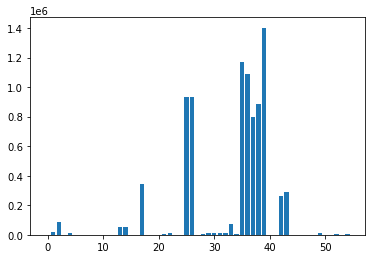

In [28]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
 
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(base_XX, y, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

- Observation:
    - From the above graph and feature values, we can say that there are almost 38 import features

In [118]:
select = SelectKBest(score_func=f_regression, k=38)
z = select.fit_transform(base_XX,y)
 
print("After selecting best 38 features:", z.shape) 
 
    
filter = select.get_support()
features = np.array(base_XX.columns)

 
print("Selected best 38:")
final_selected_features = features[filter]
print(final_selected_features)

After selecting best 38 features: (837940, 38)
Selected best 38:
['DayOfWeek' 'Promo' 'SchoolHoliday' 'Promo2' 'Year' 'Month' 'Day'
 'WeekOfYear' 'DayOfYear' 'State_holiday_before_days' 'Promo_before_days'
 'Promo_after_days' 'School_Holiday_before_days' 'CustomerPerDay'
 'CompetitionDistance' 'Promo2SinceWeek' 'Promo2SinceYear'
 'holiday_next_week' 'SalesPerDay' 'SalesPerCustomerPerDay' 'PromoOpen'
 'PromoInterval0' 'PromoInterval1' 'PromoInterval2' 'PromoInterval3'
 'Variation' 'Acceleration' 'Weekly_rolling_mean' 'Monthly_rolling_mean'
 'Previous_quarter_median' 'Previous_half_year_median'
 'Median_over_day_of_week' 'Amplitude_2' 'Amplitude_3' 'StoreType_b'
 'Assortment_a' 'Assortment_b' 'Assortment_c']


In [36]:
base_XX = base_XX[final_selected_features]
base_XX

,DayOfWeek,Promo,SchoolHoliday,Promo2,Year,Month,Day,WeekOfYear,DayOfYear,State_holiday_before_days,...,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Amplitude_2,Amplitude_3,StoreType_b,Assortment_a,Assortment_b,Assortment_c
0,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,-1.237515,...,-0.095660,0.210221,0.151726,-0.065961,-0.632146,-0.255585,1.0,1.0,0.0,0.0
1,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,-1.237515,...,1.277672,1.348807,1.423534,1.236686,1.441242,1.227970,1.0,1.0,0.0,0.0
2,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,-1.237515,...,0.876468,0.964785,0.994309,0.952665,0.587227,1.244981,1.0,0.0,1.0,0.0
3,-0.891015,-0.894026,2.045802,-0.997333,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,-1.237515,...,5.121030,4.608242,5.057815,4.507846,2.266408,2.719120,1.0,1.0,0.0,0.0
4,-0.891015,-0.894026,2.045802,1.002674,-1.071442,-1.457484,-1.707320,-1.574384,-1.592406,-1.237515,...,-0.400347,-1.421157,-0.791775,-0.659499,0.135495,-1.029922,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837935,0.854130,1.118536,-0.488806,1.002674,1.500444,0.356581,1.748584,0.521716,0.499642,-1.205207,...,-0.727043,-0.644865,-0.639163,-0.645524,-1.106845,-0.808575,0.0,1.0,0.0,0.0
837936,0.854130,1.118536,2.045802,-0.997333,1.500444,0.356581,1.748584,0.521716,0.499642,-1.205207,...,-0.537779,-0.902488,-0.789486,-1.008294,-0.237488,-0.501966,0.0,0.0,0.0,1.0
837937,0.854130,1.118536,2.045802,1.002674,1.500444,0.356581,1.748584,0.521716,0.499642,-1.205207,...,0.355961,0.176567,0.179357,-0.011196,-0.448733,-0.324074,0.0,1.0,0.0,0.0
837938,0.854130,1.118536,2.045802,1.002674,1.500444,0.356581,1.748584,0.521716,0.499642,-1.205207,...,-1.001044,-0.732517,-0.710726,-0.710298,-0.539430,-0.013099,0.0,1.0,0.0,0.0


In [37]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(base_XX,y,shuffle=False,
                                random_state=12, test_size=0.2)

In [38]:
# Training the model with Best Hyper-parameters
model = RandomForestRegressor(n_estimators=500, max_depth=80,n_jobs=-1,min_samples_leaf=3,random_state=12,min_samples_split=8)
model.fit(X_train,y_train)

train_predictions = model.predict(X_train)
test_predicitions = model.predict(X_test)
test_predicitions

array([ 8489.90759128,  7940.89669211, 12249.17978305, ...,
       10062.86843124,  6129.76077058,  8730.04828514])

In [39]:
print("RF Regressor - RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("RF Regressor - RMSPE: Metric score for test set = ",rmspe(y_test,test_predicitions))

RF Regressor - RMSPE: Metric score for train set =  0.07518364527429473
RF Regressor - RMSPE: Metric score for test set =  0.0898933150535874


In [43]:
df_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'DayOfYear', 'holidays_this_week', 'holidays_last_week',
       'holidays_next_week', 'State_holiday_before_days',
       'State_holiday_after_days', 'Promo_before_days', 'Promo_after_days',
       'School_Holiday_before_days', 'School_Holiday_after_days',
       'Sales_per_day', 'Customers_per_day', 'Sales_Per_Customers_Per_Day',
       'CompetitionOpen', 'PromoOpen', 'PromoInterval0', 'PromoInterval1',
       'PromoInterval2', 'PromoInterval3', 'Variation', 'Acceleration',
       'Weekly_rolling_mean', 'Monthly_rolling_mean',
       'Previous_quarter_median', 'Previous_half_year_median',
       'Median_over_day_of_week', 'Frequency_2', 'Frequency_3', 'Amplitude_2',
       'Amplitude_

In [71]:
# Preparing Test data
base_TT = df_test[numeric_cols]

# Handing Missinng and Scaling Numerical data
base_tt_numeric = base_TT[numeric_cols]

# Impute training data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(base_tt_numeric)

# Encode training data
scaler = StandardScaler()
X_encoded_numeric = scaler.fit_transform(X_train_imputed)


In [75]:
scaled_numeric_df = pd.DataFrame(X_encoded_numeric, columns = base_tt_numeric.columns)

In [101]:
base_categorical = df_test[categorical_cols]

# Impute training data
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(base_categorical)

# Encode training data
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded_categorical = encoder.fit_transform(X_train_imputed)

column_name = encoder.get_feature_names(['StateHoliday', 'StoreType', 'Assortment'])
scaled_categorical_df =  pd.DataFrame(X_encoded_categorical.todense(), columns= column_name)
    

In [110]:
base_submit = pd.concat([scaled_numeric_df.reset_index(drop=True), scaled_categorical_df.reset_index(drop=True)], axis=1)
base_submit = base_submit[base_XX.columns]

In [114]:
model.fit(base_XX,y)
preds = model.predict(base_submit)

In [115]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('predictions/rossmann_after_feature_selection_RF.csv', index=False)

# Model 1: Random Forest Regressor

In [130]:
#base_XX.to_csv('data_for_modeling/train_data.csv',index=False)
#base_submit.to_csv("data_for_modeling/test_data.csv",index=False)

In [2]:
base_XX = pd.read_csv("data_for_modeling/train_data.csv")
base_submit = pd.read_csv("data_for_modeling/test_data.csv")

In [119]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(base_XX,y,shuffle=False,
                                random_state=12, test_size=0.2)


# Create the parameter grid based on the results of random search 
model = RandomForestRegressor()
param_grid_rf = {
    'max_depth': [80, 90, 100 ],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}

#Instantiate the grid search model
random_search = RandomizedSearchCV(model,param_grid_rf, 
                          cv = 2, n_jobs = 8)

random_search.fit(X_train,y_train)
print(random_search.best_params_)

{'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 80}


In [123]:
# Training the model with Best Hyper-parameters
model = RandomForestRegressor(n_estimators=200, max_depth=80,n_jobs=-1,min_samples_leaf=3,random_state=12,min_samples_split=8)
model.fit(X_train,y_train)

train_predictions = model.predict(X_train)
test_predicitions = model.predict(X_test)

In [126]:
print("RF Regressor (after HPT) - RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("RF Regressor (after HPT) - RMSPE: Metric score for test set = ",rmspe(y_test,test_predicitions))

RF Regressor (after HPT) - RMSPE: Metric score for train set =  0.07606285203807295
RF Regressor (after HPT) - RMSPE: Metric score for test set =  0.09006126661770532


In [120]:
# Training the model with Best Hyper-parameters
model = RandomForestRegressor(n_estimators=500, max_depth=80,n_jobs=-1,min_samples_leaf=3,random_state=12,min_samples_split=8)
model.fit(X_train,y_train)

train_predictions = model.predict(X_train)
test_predicitions = model.predict(X_test)
test_predicitions

array([ 8489.90759128,  7940.89669211, 12249.17978305, ...,
       10062.86843124,  6129.76077058,  8730.04828514])

In [121]:
print("RF Regressor (after HPT) - RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("RF Regressor (after HPT) - RMSPE: Metric score for test set = ",rmspe(y_test,test_predicitions))

RF Regressor (after HPT) - RMSPE: Metric score for train set =  0.07518364527429475
RF Regressor (after HPT) - RMSPE: Metric score for test set =  0.08989331505358739


In [124]:
model.fit(base_XX,y)
preds = model.predict(base_submit)

In [125]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('predictions/rossmann_RF_FS_HPT.csv', index=False)

In [3]:
Image(url= "../Kaggle_result/random_forest_result.PNG", width=800, height=400)

# Model 2- XGBoost

In [21]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(base_XX,y,shuffle=False,
                                random_state=12, test_size=0.33)

from xgboost.sklearn import XGBRegressor

# Hyper-parameter Tunning 
xgb = XGBRegressor()
parameters = { 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05],
              'max_depth': [5, 6 ,7 ,10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [200,300]}

xgb_grid = RandomizedSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 8,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[21:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9644452041876472
{'subsample': 0.7, 'silent': 1, 'objective': 'reg:linear', 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [22]:
from xgboost.sklearn import XGBRegressor

xgb_model = XGBRegressor(n_estimators=300,
                         max_depth=10,
                         learning_rate=0.05,
                         min_child_weight = 4,
                         colsample_bytree = 0.7,
                         n_jobs=-1)
xgb_model.fit(X_train,y_train)

train_predictions = xgb_model.predict(X_train)
test_predicitions = xgb_model.predict(X_test)
test_predicitions

array([ 5518.5786,  5080.596 ,  6372.786 , ..., 10617.292 ,  5647.61  ,
        9568.854 ], dtype=float32)

In [30]:
print("XGBoost Regressor (after HPT) - RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("XGBoost Regressor (after HPT) - RMSPE: Metric score for test set = ",rmspe(y_test,test_predicitions))

XGBoost Regressor (after HPT) - RMSPE: Metric score for train set =  0.047038331353422065
XGBoost Regressor (after HPT) - RMSPE: Metric score for test set =  0.15078382464338455


In [26]:
xgb_model.fit(base_XX,y)
preds = xgb_model.predict(base_submit)

In [29]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('predictions/rossmann_XG_FS_HPT.csv', index=False)

In [4]:
Image(url= "Kaggle_result/XGBOOST_result.PNG", width=800, height=400)

# Model 3:  SGD Regressor

In [31]:
from xgboost.sklearn import XGBRegressor

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(base_XX,y,shuffle=False,
                                random_state=12, test_size=0.2)

model = SGDRegressor()
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 4),
    'loss': ['squared_loss'],
    'penalty': ['l2'],
    'learning_rate': ['adaptive'],
}
clf = RandomizedSearchCV(model, param_grid)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'penalty': 'l2', 'loss': 'squared_loss', 'learning_rate': 'adaptive', 'alpha': 0.001}


In [43]:
model = SGDRegressor(eta0=0.01, fit_intercept=False, shuffle=False,
                    learning_rate='adaptive',random_state=12,alpha=0.001)

model.fit(X_train,y_train)
train_predictions = model.predict(X_train)
test_prediction = model.predict(X_test)
test_prediction

array([ 8541.6781221 ,  7906.89066602, 11809.89200011, ...,
        9990.16631102,  5897.18221557,  8832.99046285])

In [46]:
test_prediction.shape

(167588,)

In [47]:
print("SGD Regressor (after HPT) - RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("SGD Regressor (after HPT) - RMSPE: Metric score for test set = ",rmspe(y_test,test_prediction))

SGD Regressor (after HPT) - RMSPE: Metric score for train set =  0.12101601574219796
SGD Regressor (after HPT) - RMSPE: Metric score for test set =  0.10764963468536305


In [48]:
model.fit(base_XX,y)
preds = model.predict(base_submit)

In [49]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('predictions/rossmann_SGD_FS_HPT.csv', index=False)

In [102]:
Image(url= "Kaggle_result/SGD_result.PNG", width=800, height=400)

# Model 4: stacking Regressor

In [50]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(base_XX,y,shuffle=False,
                                random_state=12, test_size=0.2)


In [51]:
# Stacking Regressor : http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

from mlxtend.regressor import StackingRegressor

reg_model1 = SGDRegressor(eta0=0.01, fit_intercept=False, shuffle=False,
                    learning_rate='adaptive',random_state=12,alpha=0.001)

reg_model2 = RandomForestRegressor(n_estimators=200, 
                                   max_depth=80,
                                   n_jobs=-1,
                                   min_samples_leaf=3,
                                   random_state=12,
                                   min_samples_split=8)

reg_model3 = XGBRegressor(n_estimators=300,
                         max_depth=10,
                         learning_rate=0.05,
                         min_child_weight = 4,
                         colsample_bytree = 0.7,
                         n_jobs=-1)

stacked_regessor = StackingRegressor(regressors=[reg_model1, reg_model2, reg_model3], 
                           meta_regressor=reg_model2)

stacked_regessor.fit(X_train, y_train)

train_predictions = stacked_regessor.predict(X_train)
test_predicitions = stacked_regessor.predict(X_test)
test_predicitions

array([ 8421.57411366,  7951.1169088 , 12137.34107173, ...,
       10171.25318497,  6208.78959916,  8898.98997274])

In [53]:
print("Stacking Regressor (after HPT) - RMSPE: Metric score for train set = ",rmspe(y_train,train_predictions))
print("Stacking Regressor (after HPT) - RMSPE: Metric score for test set = ",rmspe(y_test,test_predicitions))

Stacking Regressor (after HPT) - RMSPE: Metric score for train set =  0.03878772764405638
Stacking Regressor (after HPT) - RMSPE: Metric score for test set =  0.08514293143102773


In [54]:
model.fit(base_XX,y)
preds = model.predict(base_submit)

In [55]:
#Defining a new dataframe to contain the predictions according to the IDs.
df_ypred = pd.DataFrame()
df_ypred['Id'] = ids

# Scale back the log of sales to sales.
df_ypred['Sales'] = preds  

for i in range(len(df_ypred)):

    id = df_ypred.iloc[i]['Id']
    if id in closed_test_ids or b:
        df_ypred.iloc[i]['Sales'] = 0
    else:
        continue

#Sorting values according to ID
df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('predictions/rossmann_Stacking_FS_HPT.csv', index=False)

In [103]:
Image(url= "Kaggle_result/stacking_classifier_result.PNG", width=800, height=400)

# Final Results

In [69]:
columns = ['Model','train rmspe','test rmspe','Kaggle private score']
result = [ ["Random Forest",0.07,0.09,0.41],
           ["XG Boost",0.04,0.15,0.44],
           ["SGD Regressor",0.12,0.10,0.52],
           ["Stacking Regressor",0.038,0.085,0.52]]

final_result = pd.DataFrame(result,columns=columns)
final_result.set_index("Model")

,train rmspe,test rmspe,Kaggle private score
Model,,,
Random Forest,0.070,0.090,0.41
XG Boost,0.040,0.150,0.44
SGD Regressor,0.120,0.100,0.52
Stacking Regressor,0.038,0.085,0.48
